# Imports

In [1]:
import copy
import os
import pandas
import shutil
import matplotlib.pyplot as plt
from molgroups.support import molstat
from molgroups.infotheory import entropy
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# always use the same testdata
shutil.copyfile('./bu/H-D_DMPC_D2O_35C_FQ.ABS', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/H-D_DMPC_35D2O_35C_FQ.ABS', os.getcwd()+'/sim1.dat')
shutil.copyfile('./bu/H-D_DMPC_H2O_35C_FQ.ABS', os.getcwd()+'/sim2.dat')

'/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/sim2.dat'

# Variables for example fit and optimization

In [2]:
# Run Optimization or only example fit and data simulation
RunFit = True
RunOptimization=False

# Folders and fit application
store = "T"
setupdir = os.getcwd()
runfile = "run"
fitsource = "SASView"

# Fit iterations in example fit and optimization
burn=5000
steps=100

# Optimization-specific parameters

# enforced qmin and qmax, even if detector would cover larger q-range
# alternatively: take enforced q-range from first provided data file (index 0)
# set total counting time for the entire experiment (in s), or None
# number of gpcam iterations, if gpcam is used
qmin = 0.02
qmax = 0.5
qrangefromfile = False
t_total = None
optimizer = 'gpcam'  # optimizer can be 'grid' or gpcam

# only used for gpcam optimizer
gpcam_iterations = 1200
gpcam_init_dataset_size = 50  # usually 20
gpcam_step = 10                # at least 2 to make use of local and global optimization
# Acquisition Functions. Use "variance" for pure exploration, 'maximum' to zero in on an already identified information gain maximum, 'ucb' for an exploration-exploitation balance, and 'shannon_ig_vec' for a maximization in information gain.
acq_func='shannon_ig_vec'

# only used for grid optimizer
convergence = 2.0           # convergence criteria for internal robustness check
miniter = 3                 # minimum number of samples per grid point, chose at least 2 for error bars
bcalcsymmetric = True       # if problem is symmetric in variable parameters, should symmetric solutions be calculated twice?

# isotropic scattering background
# user-defined linear relationship between a SLD of the bulk solvent and the differential macroscopic scattering crosssection of the buffer
#cross_section_background = {'slope':-0.1626, 'y_intercept': 0.7980}  # acetonitrile
#mode = 'SANS_linear'
# presets for water
mode = 'water'
cross_section_background = None

# Prepare gpcam to keep plots for individual iterations and make fine enough steps between record keeping. Useful for constructing a movie.
# If not needed, set keep_plots to False, init dataset size to 20, do not show support points, and set gpcam steps to None
keep_plots = False
show_support_points = False

# misc entropy setup
bClusterMode = False
bFetchMode = False
time = 2
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = ['#!/bin/bash\n',
          '#SBATCH --job-name=entro {mcmc_iteration}\n',
          '#SBATCH -A mc4s9np\n', '#SBATCH -p RM\n',
          '#SBATCH -t 0' + str(time) + ':00:00\n',
          '#SBATCH -N 4\n', '#SBATCH --ntasks-per-node 28\n',
          '\n',
          'set +x\n',
          'cd $SLURM_SUBMIT_DIR\n',
          '\n',
          'module load python/2.7.11_gcc\n',
          'export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n',
          '\n',
          'mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time='
          + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn)
          + ' --steps=' + str(steps) + '\n'
          ]
# script.append('cd '+dirname+'\n')

# Create Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%write_and_run run.py
from bumps.names import *
import bumps.curve
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids

import numpy

# constants
dimension = 100
stepsize = 1.
z = numpy.linspace(0, 99, 100, endpoint=True)

def bilayer(z, bulknsld, l_lipid1, l_lipid2, sigma=3.0, vf_bilayer=1.0, frac_deut=0.9):
    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6

    # make sure frac_deut remains within limits. The optimization lets it go beyond for the extreme cases.
    if frac_deut>1.0:
        frac_deut = 1.0
    if frac_deut<0.0:
        frac_deut = 0.0

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, startz=20., l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer, nf_lipids=[1-frac_deut, frac_deut])

    # print(z)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', np.arange(dimension) * stepsize)
    problem.results = blm.fnWriteResults2Dict({}, 'bilayer')
    # Return nSLD profile in Refl1D units
    return nsld*1e6

def Dummy(x, l_lipid=11., sigma=3.0, frac_deut=0.9):
    #################################################
    # bilayer update
    sldarr0 = bilayer(z, float(model0.sld_solvent.value), l_lipid, l_lipid, sigma=sigma, frac_deut=frac_deut)
    sldarr1 = bilayer(z, float(model1.sld_solvent.value), l_lipid, l_lipid, sigma=sigma, frac_deut=frac_deut)
    sldarr2 = bilayer(z, float(model2.sld_solvent.value), l_lipid, l_lipid, sigma=sigma, frac_deut=frac_deut)
    for i in range(pars0['n']):
        getattr(model0, 'sld'+str(i+1)).value = sldarr0[i]
        getattr(model1, 'sld'+str(i+1)).value = sldarr1[i]
        getattr(model2, 'sld'+str(i+1)).value = sldarr2[i]
        getattr(model0, 'thickness'+str(i+1)).value = 1.
        getattr(model1, 'thickness'+str(i+1)).value = 1.
        getattr(model2, 'thickness'+str(i+1)).value = 1.

    result = numpy.array([1., 2., 3.])
    return result

### Define bilayer object
myristoyl = cmp.Component(name='myristoyl', formula='C13 H27', cell_volume=782./2.0, length=11.0)
dmyristoyl = cmp.Component(name='myristoyl', formula='C13 D27', cell_volume=782./2.0, length=11.0)
DMPC = cmp.Lipid(name='DMPC', headgroup=lipids.PC, tails=2 * [myristoyl], methyls=[cmp.methyl])
dDMPC = cmp.Lipid(name='dDMPC', headgroup=lipids.PC, tails=2 * [dmyristoyl], methyls=[cmp.Dmethyl])
blm = mol.BLM(lipids=[DMPC, dDMPC], lipid_nf=[0.1, 0.9])

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
data1 = load_data('sim1.dat')
data2 = load_data('sim2.dat')

# setting qmin and qmax here will interfere with data simulation for optimization
# qmin = 0.02
# qmax = 0.40
# setattr(data0, 'qmin', qmin)
# setattr(data0, 'qmax', qmax)
# setattr(data1, 'qmin', qmin)
# setattr(data1, 'qmax', qmax)
# setattr(data2, 'qmin', qmin)
# setattr(data2, 'qmax', qmax)

# DEFINE THE MODEL
# copied and initialized the custom model with up to 100 sld and thickness parameters in sasmodels/models
# a second hard-coded limit in sasmodels/modelinfo.py line 594 was manually increased from 20 to 120.
# further in sasmodels/data.py replace all imports from sas.sascalc. ... to from sasdata. ...
kernel = load_model('my_core_multi_shell@hardsphere')

pars0 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=2.4, radius=500.0, radius_pd=0.33, n=100, radius_effective=60.0, volfraction=0.01)
pars1 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=500.0, radius_pd=0.33, n=100, radius_effective=60.0, volfraction=0.01)
pars2 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=500.0, radius_pd=0.33, n=100, radius_effective=60.0, volfraction=0.01)

model0 = Model(kernel, **pars0)
model1 = Model(kernel, **pars1)
model2 = Model(kernel, **pars2)

# Bilayer specific-parameters are passed into a dummy function
xfoo = numpy.array([1., 2., 3.])
yfoo = numpy.array([1., 2., 3.])
dyfoo = numpy.array([0.01, 0.01, 0.01])
M0 = Curve(Dummy, xfoo, yfoo, dyfoo, l_lipid=11., sigma=3., frac_deut=0.9)
M0.l_lipid.range(8, 12)
M0.sigma.range(2.0, 3.0)
M0.frac_deut.range(0.7, 0.99)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
background0 = Parameter(name='background0', value=0.4).range(0.01, 2.0)
background1 = Parameter(name='background1', value=0.4).range(0.01, 2.0)
background2 = Parameter(name='background2', value=0.4).range(0.01, 2.0)
sld_solvent0 = sld_core0 = Parameter(name='sld_solvent0', value=2.0).range(6.2, 6.4)
sld_solvent1 = sld_core1 = Parameter(name='sld_solvent1', value=2.0).range(1.0, 3.)
sld_solvent2 = sld_core2 = Parameter(name='sld_solvent2', value=2.0).range(-0.56, -0.54)
scale0 = Parameter(name='scale0', value=0.1).range(0.01, 15.0)
scale1 = scale2 = scale0
vf0 = Parameter(name='vf0', value=0.1).range(0.01, 0.1)
#vf1 = Parameter(name='vf1', value=0.1).range(0.01, 0.4)
#vf2 = Parameter(name='vf2', value=0.1).range(0.01, 0.4)
vf1 = vf2 = vf0

#pd0 = Parameter(name='pd0', value=0.1).range(0.01, 0.5)
#pd1 = Parameter(name='pd1', value=0.1).range(0.01, 0.5)
#pd2 = Parameter(name='pd2', value=0.1).range(0.01, 0.5)

model0.scale = scale0
model0.background = background0
model0.sld_solvent = sld_solvent0
model0.sld_core = sld_core0
#model0.radius.range(40., 1200.)
#model0.radius_pd = pd0
model0.radius_effective = model0.radius + 50.
model0.volfraction = vf0

model1.scale = scale1
model1.background = background1
model1.sld_solvent = sld_solvent1
model1.sld_core = sld_core1
#model1.radius = model0.radius
#model1.radius_pd = pd1
model1.radius_effective = model0.radius
model1.volfraction = vf1

model2.scale = scale2
model2.background = background2
model2.sld_solvent = sld_solvent2
model2.sld_core = sld_core2
#model2.radius = model0.radius
#model2.radius_pd = pd2
model2.radius_effective = model0.radius
model2.volfraction = vf2

M1 = Experiment(data=data0, model=model0)
M2 = Experiment(data=data1, model=model1)
M3 = Experiment(data=data2, model=model2)

problem = MultiFitProblem([M0, M1, M2, M3])

2. Run Example Fit

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/T/run.py
No state to reload.
# steps: 100, # draws: 11000
step 1 cost 1131.010(19)
                               frac_deut .....|....    0.85653 in (0.7,0.99)
                                 l_lipid ......|...    10.4629 in (8,12)
                                   sigma .........|    2.95419 in (2,3)
                             background0 |.........  0.0296028 in (0.01,2)
                                  scale0 ....|.....    7.19092 in (0.01,15)
                            sld_solvent0 .........|    6.38564 in (6.2,6.4)
                                     vf0 |.........  0.0152056 in (0.01,0.1)
                             background1 ....|.....    0.91936 in (0.01,2)
                            sld_solvent1 .|........    1.39151 in (1,3)
                             background2 ....|.....   0.931097

Process SpawnPoolWorker-8:
Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/bumps-0.9.0-py3.8.egg/bumps/mapper.py", line 126, in _MP_run_problem
    return MPMapper.problem.nllf(point)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/bumps-0.9.0-py3.8.egg/bumps/fitproblem.py", line 477, in nllf
    pparameter, pconstraints, pmodel = s

-- Model 0 
.frac_deut = 0.860535 in [0.7,0.99]
.l_lipid = 10.3759 in [8,12]
.sigma = 2.96658 in [2,3]

[chisq=0.0(12), nllf=0]
-- Model 1 sim0.dat
.background = background0 = 0.0652419 in [0.01,2]
.n = 100
.radius = 500
.radius_effective = (radius + 50.0) = 550
.radius_effective_mode = 1
.radius_pd = 0.33
.radius_pd_n = 35
.radius_pd_nsigma = 3
.scale = scale0 = 1.71642 in [0.01,15]
.sld1 = 6.24842
.sld10 = 6.24817
.sld100 = 6.24842
.sld100_M0 = 0
.sld100_mphi = 0
.sld100_mtheta = 0
.sld10_M0 = 0
.sld10_mphi = 0
.sld10_mtheta = 0
.sld11 = 6.24752
.sld11_M0 = 0
.sld11_mphi = 0
.sld11_mtheta = 0
.sld12 = 6.2455
.sld12_M0 = 0
.sld12_mphi = 0
.sld12_mtheta = 0
.sld13 = 6.23992
.sld13_M0 = 0
.sld13_mphi = 0
.sld13_mtheta = 0
.sld14 = 6.22616
.sld14_M0 = 0
.sld14_mphi = 0
.sld14_mtheta = 0
.sld15 = 6.19584
.sld15_M0 = 0
.sld15_mphi = 0
.sld15_mtheta = 0
.sld16 = 6.13614
.sld16_M0 = 0
.sld16_mphi = 0
.sld16_mtheta = 0
.sld17 = 6.03112
.sld17_M0 = 0
.sld17_mphi = 0
.sld17_mtheta = 0
.sld18 = 

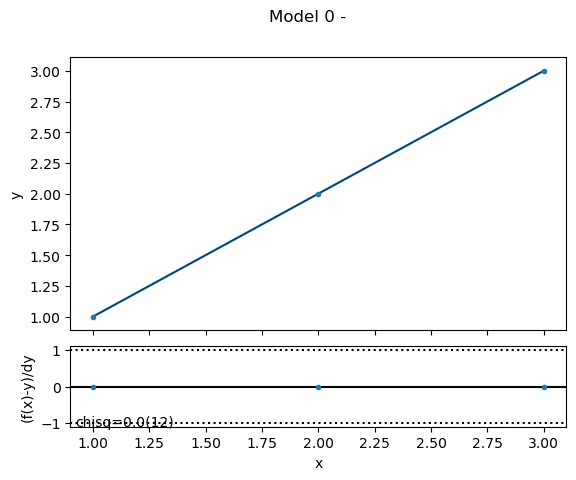

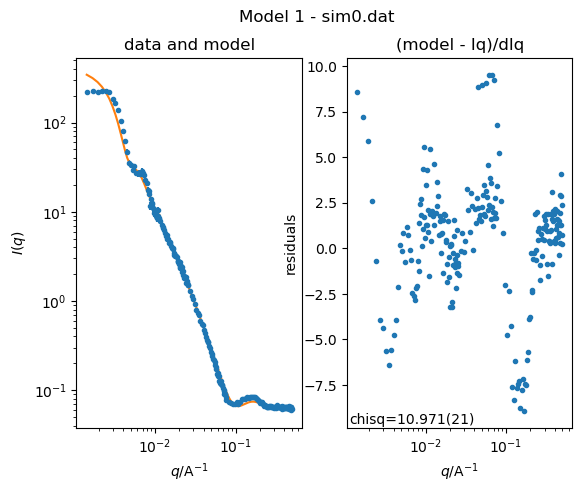

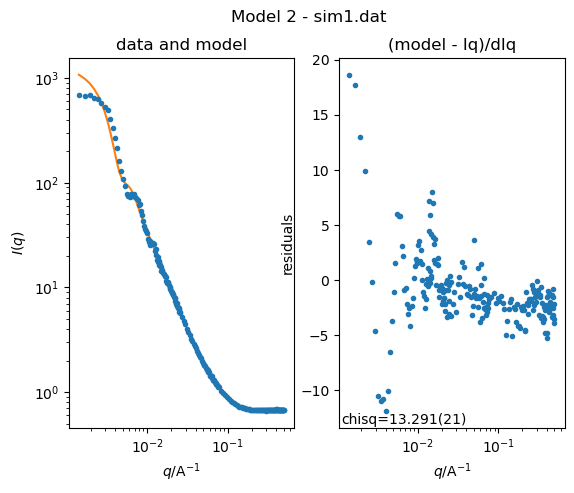

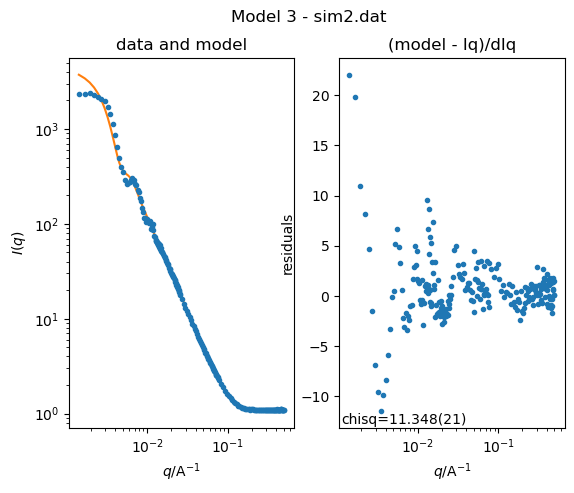

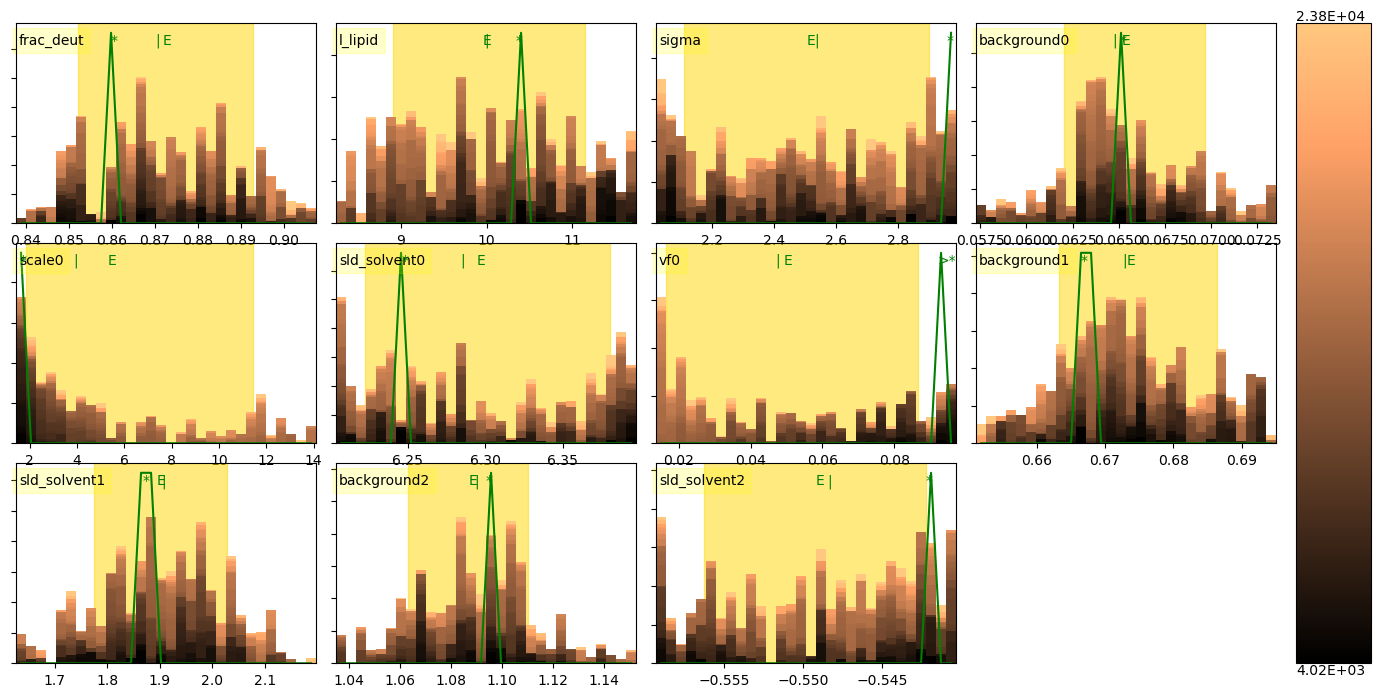

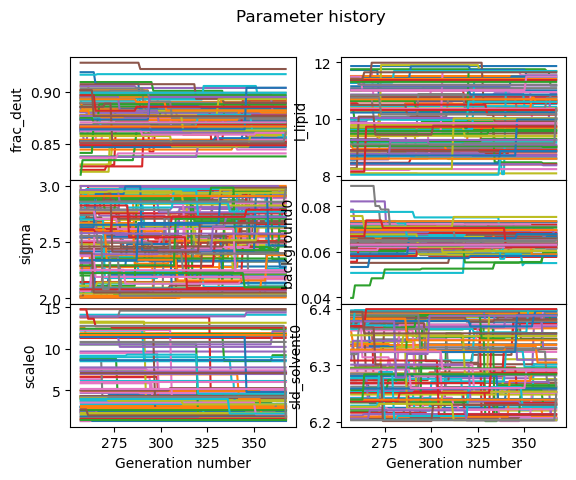

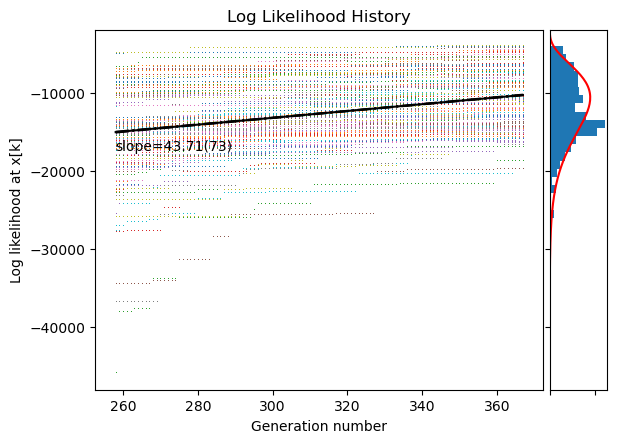

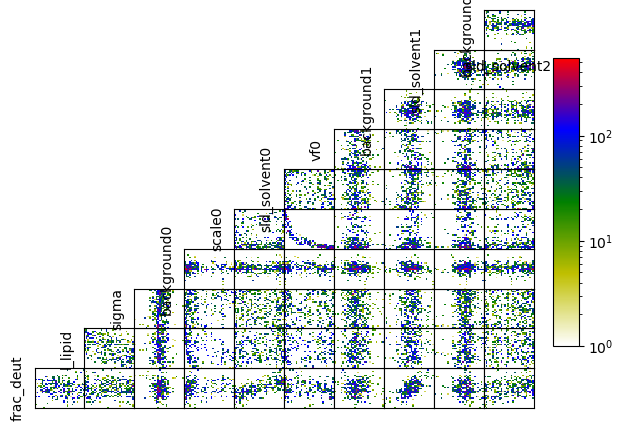

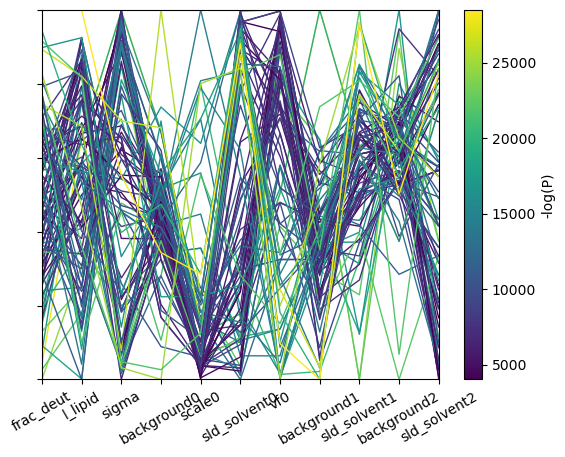

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    # remove store directory if it already exists
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fitobj.fnRestoreFit()

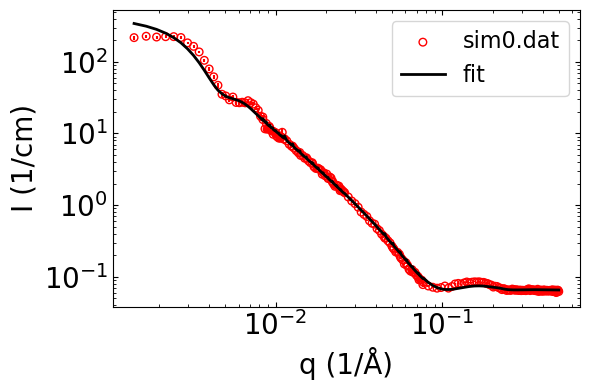

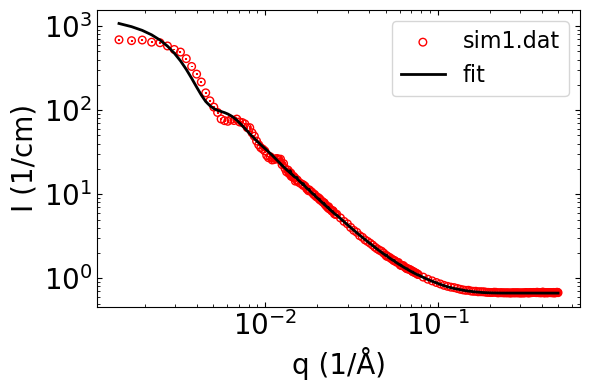

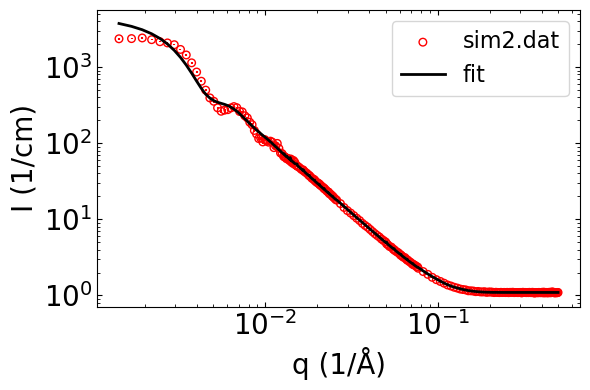

In [5]:
#pd = [None, data0.x[(data0.x >= qmin) & (data0.x <= qmax)], data1.x[(data1.x >= qmin) & (data1.x <= qmax)], data2.x[(data2.x >= qmin) & (data2.x <= qmax)]]
#pd2 = [None, data0.dx[(data0.x >= qmin) & (data0.x <= qmax)], data1.dx[(data1.x >= qmin) & (data1.x <= qmax)], data2.dx[(data2.x >= qmin) & (data2.x <= qmax)]]
pd = [None, data0.x, data1.x, data2.x]
pd2 = [None, data0.dx, data1.dx, data2.dx]

#bg = [None, 0.06548, 0.6729, 1.0937]
bg = [0., 0., 0., 0.]
i=0
for M in fitobj.Interactor.problem.models:
    M.chisq()
    theo = M.fitness.theory()
    if not isinstance(M.fitness, bumps.curve.Curve):
        fig, ax = plt.subplots()
        ax.errorbar(pd[i], M.fitness.Iq-bg[i], yerr=M.fitness.dIq, ls='none', color='r')
        ax.scatter(pd[i], M.fitness.Iq-bg[i], s=30, marker='o', facecolors='none', edgecolors='r', label=M.fitness.name)
        ax.plot(pd[i], theo-bg[i], label="fit", color='black', linewidth=2)
        ax.legend(loc="upper right", fontsize=16)
        plt.xlabel("q (1/Å)", fontsize=20)
        plt.ylabel("I (1/cm)", fontsize=20)
        ax.minorticks_on()
        ax.tick_params(which="both", direction="in", labelsize=20)
        ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax.set_yscale('log')
        ax.set_xscale('log')
        #plt.xlim(0, 100)
        #plt.ylim(1e-3, 100)
        #plt.xticks(numpy.arange(-35, 36, 5.0))
        #plt.grid(True, which='Both')
        fig.patch.set_facecolor('white')
        ax.figure.set_size_inches(6, 4)
        plt.tight_layout()
        plt.savefig(os.path.join(store, "IvsQ"+str(i)), facecolor="white")
        plt.show()
        numpy.savetxt(os.path.join(store, "IvsQ"+str(i)+".dat"), numpy.c_[pd[i], M.fitness.Iq, M.fitness.dIq, pd2[i], theo], delimiter=' ', header="Q Iq dIq dQ fit")
    i+=1

In [6]:
sparse = 0.05
fitobj.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of MCMC fit ...
Number of iterations: 605

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence
0,fit,frac_deut,[ |-| ],0.70,0.99,0.851142,0.869783,0.890858,-0.018640,0.021076,0.682689
1,fit,l_lipid,[ | - | ],8.00,12.00,8.903174,10.021099,11.085809,-1.117925,1.064710,0.682689
2,fit,sigma,[ | - | ],2.00,3.00,2.109819,2.505821,2.892053,-0.396002,0.386232,0.682689
3,fit,background0,[+ ],0.01,2.00,0.061583,0.064564,0.069493,-0.002981,0.004928,0.682689
4,fit,scale0,[ |- | ],0.01,15.00,1.874303,3.708668,11.302980,-1.834365,7.594313,0.682689
...,...,...,...,...,...,...,...,...,...,...,...
57,bilayer,thickness_inner_leaflet,,NaN,NaN,10.190694,11.470286,12.688968,-1.279592,1.218681,0.682689
58,bilayer,thickness_outer_leaflet,,NaN,NaN,10.190694,11.470286,12.688968,-1.279592,1.218681,0.682689
59,bilayer,water in inner headgroups,,NaN,NaN,0.451414,0.495771,0.540828,-0.044357,0.045057,0.682689
60,bilayer,water in hydrocarbons,,NaN,NaN,0.025512,0.040978,0.059801,-0.015466,0.018823,0.682689


Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat. Plot the median bilayer profile

In [7]:
fitobj.fnProfilesStat()
pandas.DataFrame(fitobj.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,bilayer.defect_hg
1,bilayer.defect_hc
2,bilayer.headgroup1_1
3,bilayer.headgroup1_1.carbonyl_glycerol
4,bilayer.headgroup1_1.choline
5,bilayer.headgroup1_1.phosphate
6,bilayer.headgroup1_2
7,bilayer.headgroup1_2.carbonyl_glycerol
8,bilayer.headgroup1_2.choline
9,bilayer.headgroup1_2.phosphate


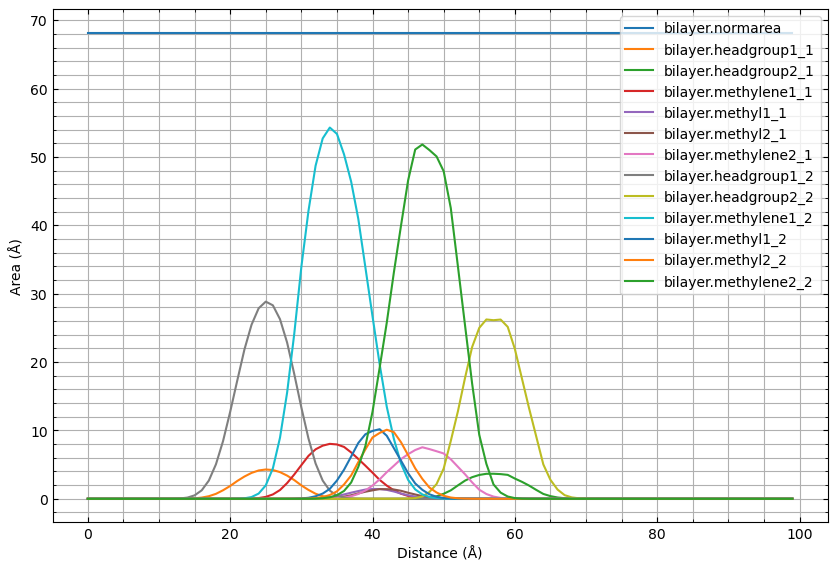

In [8]:
import matplotlib.pyplot as plt

median=['bilayer.normarea', 'bilayer.headgroup1_1', 'bilayer.headgroup2_1', 'bilayer.methylene1_1', 'bilayer.methyl1_1', 'bilayer.methyl2_1', 'bilayer.methylene2_1', 'bilayer.headgroup1_2', 'bilayer.headgroup2_2', 'bilayer.methylene1_2', 'bilayer.methyl1_2', 'bilayer.methyl2_2', 'bilayer.methylene2_2']
uncertainties=[]

fig, ax = plt.subplots()
for gp in median:
    zaxis = fitobj.diStatResults['Molgroups'][gp]['zaxis']
    area = fitobj.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=gp)
    if gp in uncertainties:
        msigma = fitobj.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fitobj.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area (Å)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

## Test Data Simulation
1. Show Best-fit parameters from above fit

In [9]:
df = pandas.read_csv(os.path.join(setupdir, store, runfile+'.par'), sep='\s+', header=None, names=['Parameter', 'Fit Value'])
df

,Parameter,Fit Value
0,frac_deut,0.860535
1,l_lipid,10.375915
2,sigma,2.966579
3,background0,0.065242
4,scale0,1.716418
5,sld_solvent0,6.248422
6,vf0,0.097994
7,background1,0.666975
8,sld_solvent1,1.873211
9,background2,1.094820


2. Define simulation model parameters. They are written out to simpar.dat. Please change to desired values or copy from dataframe above.

In [10]:
text = [
    'frac_deut 0.915717',
    'l_lipid 10.923830',
    'sigma 2.464736',
    'background0 0.063936',
    'scale0 12.337908',
    'sld_solvent0 6.279241',
    'vf0 0.018106',
    'background1 0.673297',
    'scale1 8.613782',
    'sld_solvent1 2.195019',
    'background2 1.095051',
    'scale2 7.488559',
    'sld_solvent2 -0.552544'
]

f=open('simpar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

3. Define Instrument configurations. Each dataset can have its own instrument configuration. In the example below, a single configuration is assigned to all datasets. The configuration is made of three settings with different sample-detector distances.

In [11]:
# buffer is not subtracted but treated as a fitting parameter
sb = 0.0

configuration_dataset1 = [{'lambda': 6.0,
                            "sample_detector_distance": 120,
                            'source_sample_distance': 387.6,
                            'source_aperture_radius':5.08*0.5,
                            'sample_aperture_radius':1.27*0.5,
                            "beamstop_diameter": 10.16,
                            "neutron_flux": 2e5,
                            'time': 600,
                            'beam_center_x': 25,
                            "dlambda_lambda":0.136,
                            "differential_cross_section_buffer": sb,
                            "cuvette_thickness": 0.1},
                          {'lambda': 6.0,
                           "sample_detector_distance": 650,
                           'source_sample_distance': 850.05,
                           'source_aperture_radius':5.08*0.5,
                           'sample_aperture_radius':1.27*0.5,
                           "beamstop_diameter": 10.16,
                           "neutron_flux": 2e5,
                           'time': 600,
                           "dlambda_lambda":0.136,
                           "differential_cross_section_buffer": sb,
                           "cuvette_thickness": 0.1},
                         {'lambda': 6.0,
                          "sample_detector_distance": 1800,
                          'source_sample_distance': 1467,
                          'source_aperture_radius':5.08*0.5,
                          'sample_aperture_radius':1.27*0.5,
                          "dlambda_lambda":0.136,
                          "beamstop_diameter": 7.62,
                          "neutron_flux": 8e4,
                          'time': 1800,
                          "differential_cross_section_buffer": sb,
                          "cuvette_thickness": 0.1}]

configuration = [configuration_dataset1, copy.deepcopy(configuration_dataset1), copy.deepcopy(configuration_dataset1)]

4. Visually check configuration.

In [12]:
df = pandas.DataFrame.from_dict(configuration_dataset1)
df

,lambda,sample_detector_distance,source_sample_distance,source_aperture_radius,sample_aperture_radius,beamstop_diameter,neutron_flux,time,beam_center_x,dlambda_lambda,differential_cross_section_buffer,cuvette_thickness
0,6.0,120,387.60,2.54,0.635,10.16,200000.0,600,25.0,0.136,0.0,0.1
1,6.0,650,850.05,2.54,0.635,10.16,200000.0,600,NaN,0.136,0.0,0.1
2,6.0,1800,1467.00,2.54,0.635,7.62,80000.0,1800,NaN,0.136,0.0,0.1


5. Simulate data.

In [13]:
fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=qmin, qmax=qmax, t_total=None)

             par      value
0      frac_deut   0.915717
1        l_lipid  10.923830
2          sigma   2.464736
3    background0   0.063936
4         scale0  12.337908
5   sld_solvent0   6.279241
6            vf0   0.018106
7    background1   0.673297
8         scale1   8.613782
9   sld_solvent1   2.195019
10   background2   1.095051
11        scale2   7.488559
12  sld_solvent2  -0.552544
[[{'lambda': 6.0, 'sample_detector_distance': 120, 'source_sample_distance': 387.6, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 200000.0, 'time': 600, 'beam_center_x': 25, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.0, 'cuvette_thickness': 0.1}, {'lambda': 6.0, 'sample_detector_distance': 650, 'source_sample_distance': 850.05, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 200000.0, 'time': 600, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 

/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


### Compare original and simulated data.
1. Compare Data

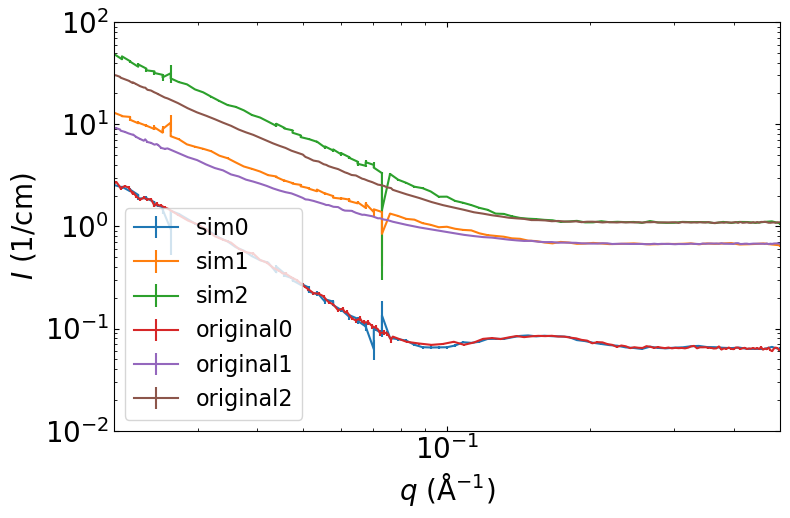

In [14]:
import pandas

fig, ax = plt.subplots()

original0 = pandas.read_csv(os.path.join('bu','H-D_DMPC_D2O_35C_FQ.ABS'), sep='\s+', skip_blank_lines=True, skiprows=5, names=['Q', 'I', 'dI', 'dQ', 'msc1', 'msc2'], comment='#')
simdata0 = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True, comment='#')
original1 = pandas.read_csv(os.path.join('bu','H-D_DMPC_35D2O_35C_FQ.ABS'), sep='\s+', skip_blank_lines=True, skiprows=5, names=['Q', 'I', 'dI', 'dQ', 'msc1', 'msc2'], comment='#')
simdata1 = pandas.read_csv('sim1.dat', sep=' ', skip_blank_lines=True,comment='#')
original2 = pandas.read_csv(os.path.join('bu','H-D_DMPC_H2O_35C_FQ.ABS'), sep='\s+', skip_blank_lines=True, skiprows=5, names=['Q', 'I', 'dI', 'dQ', 'msc1', 'msc2'], comment='#')
simdata2 = pandas.read_csv('sim2.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.errorbar(simdata0['Q'], simdata0['I'], simdata0['dI'], label="sim0")
ax.errorbar(simdata1['Q'], simdata1['I'], simdata1['dI'], label="sim1")
ax.errorbar(simdata1['Q'], simdata2['I'], simdata2['dI'], label="sim2")
ax.errorbar(original0['Q'], original0['I'], original0['dI'], label="original0")
ax.errorbar(original1['Q'], original1['I'], original1['dI'], label="original1")
ax.errorbar(original2['Q'], original2['I'], original2['dI'], label="original2")

ax.legend(fontsize=16)
ax.set_ylabel("$I$ (1/cm)", fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=20)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=20)
ax.figure.set_size_inches(8, 8*0.66)
ax.set_xlim(qmin, qmax)
ax.set_ylim(1e-2, 1e2)
plt.tight_layout()
plt.savefig(store + "/intensity_comparison.png", facecolor="white")
plt.show()

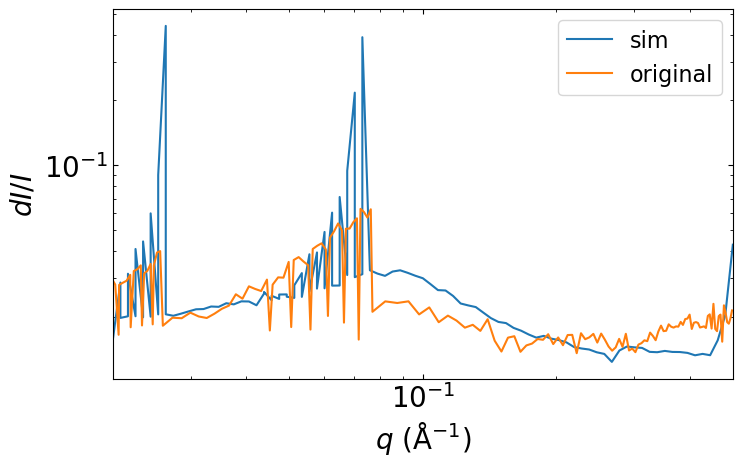

In [15]:
fig, ax = plt.subplots()

original = pandas.read_csv(os.path.join('bu','H-D_DMPC_D2O_35C_FQ.ABS'), sep='\s+', skip_blank_lines=True, skiprows=5, names=['Q', 'I', 'dI', 'dQ', 'msc1', 'msc2'], comment='#')
simdata = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True, comment='#')

ax.plot(simdata['Q'], (simdata['dI']/simdata['I']), label="sim")
ax.plot(original['Q'], (original['dI']/original['I']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("$dI/I$", fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=20)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=20)
ax.figure.set_size_inches(8, 8*0.6)
ax.set_xlim(qmin, qmax)
#ax.set_ylim(0, 0.25)
plt.savefig(store + "/uncertainty_comparison.png", facecolor="white")
plt.show()

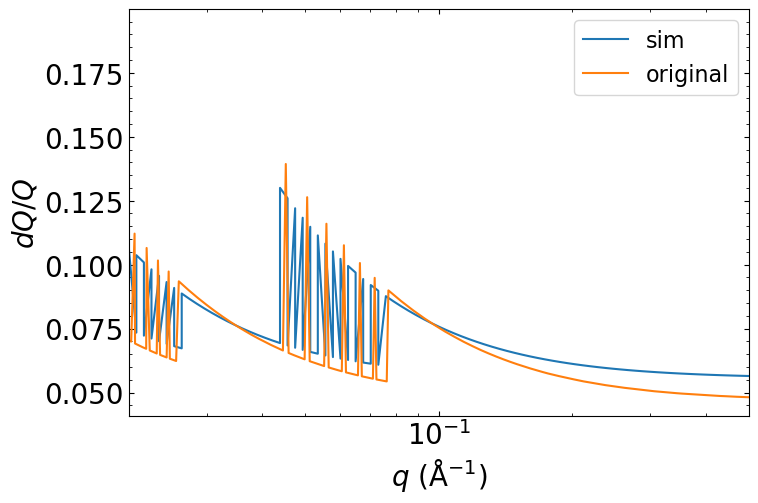

In [16]:
fig, ax = plt.subplots()

original = pandas.read_csv(os.path.join('bu','H-D_DMPC_D2O_35C_FQ.ABS'), sep='\s+', skip_blank_lines=True, skiprows=5, names=['Q', 'I', 'dI', 'dQ', 'msc1', 'msc2'], comment='#')
simdata = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True, comment='#')
ax.plot(simdata['Q'], (simdata['dQ']/simdata['Q']), label="sim")
ax.plot(original['Q'], (original['dQ']/original['Q']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("$dQ/Q$", fontsize=20)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=20)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=20)
ax.figure.set_size_inches(8, 8*0.66)
#ax.set_ylim(0, 0.01)
ax.set_xlim(qmin, qmax)
plt.savefig(store + "/resolution_comparison.png", facecolor="white")
plt.show()

# Experimental Optimization
1. Create a data file (entropypar.dat) that sets the values and fit ranges for model parameters, values for configuration parameters, and designates paramters to optimize.

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries.
* Configuration parameters are given by a preceeding n x y, where x is the data set it applies to and y the configuration number. Specifying x,y = '*' makes this parameter apply to all configurations.
* Any numbers x y following a fit parameter indicates that this paramter is used for this particular dataset/configuration to determine the background (incoherent crosssection). This typically applies to SLDs. The 'mode' argument for entropy.Entropy() then determines whether this is to be interpreted as an aqueous solvent or other. Sometimes, instead of subtracting an incoherent crosssection from the data, a background parameter is retained in the model. If any of the parameters is asigned an x = bi, this background will be se to the incoherent (isotropic) crosssection of the ith data set, instead of applying this value to the configuration. Fit boundaries for such backgrounds must be large enough to encompass all possible outcomes. They will not be updated dynamically.
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step).
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* If an instrumental parameter is specified for one data set, the instrumental parameter needs to be specified for all other datasets, as well.
* Data filenames are currently limited to sim.dat for a single file fit, or simx.dat, x = 0 ... n, for fits with multiple data sets

In [17]:
text = [
        'i b0 * background0 0.063936 0.0 1.5',
        'i b1 * background1 0.673297 0.0 1.5',
        'i b2 * background2 1.095051 0.0 1.5',
        'i * * frac_deut 0.9 0.89 0.91 0 1. 0.01',
        'd * * l_lipid 10.923830 8.0 12.0',
        'd * * sigma 2.5 1.0 5.0',
        'i * * scale0 10.0 5.0 15.0',
        'i * * vf0 0.02 0.01 0.10',
        'i 0 * sld_solvent0 -0.5 -0.6 -0.4 -0.5 3.0 0.1',
        'i 1 * sld_solvent1 6.5 6.4 6.6 3.0 6.5 0.1',
        'i 2 * sld_solvent2 3.0 2.9 3.1 -0.5 6.5 0.1',
        'n * * lambda 6.00',
        'n * * differential_cross_section_buffer 0.0',
        'n * 0 sample_detector_distance 120',
        'n * 1 sample_detector_distance 650',
        'n * 2 sample_detector_distance 1800',
        'n * 0 source_sample_distance 387.6',
        'n * 1 source_sample_distance 850.05',
        'n * 2 source_sample_distance 1467',
        'n * 0 neutron_flux 2e5',
        'n * 1 neutron_flux 2e5',
        'n * 2 neutron_flux 8e4',
        'n * * source_aperture_radius 2.54',
        'n * * sample_aperture_radius 0.635',
        'n * * dlambda_lambda 0.136',
        'n * 0 beamstop_diameter 10.16',
        'n * 1 beamstop_diameter 10.16',
        'n * 2 beamstop_diameter 7.62',
        'n * 0 time 600',
        'n * 1 time 600',
        'n * 2 time 1800',
        'n * 0 beam_center_x 25.',
        'n * * cuvette_thickness 0.1'
        ]

f=open('entropypar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

header_names = ['type', 'dataset', 'config.', 'parameter', 'value', 'l_fit', 'u_fit', 'l_opt', 'u_opt', 'step_opt']
df = pandas.read_csv('entropypar.dat', sep='\s+', header=None, names=header_names, skip_blank_lines=True, comment='#')
df

,type,dataset,config.,parameter,value,l_fit,u_fit,l_opt,u_opt,step_opt
0,i,b0,*,background0,0.063936,0.00,1.50,NaN,NaN,NaN
1,i,b1,*,background1,0.673297,0.00,1.50,NaN,NaN,NaN
2,i,b2,*,background2,1.095051,0.00,1.50,NaN,NaN,NaN
3,i,*,*,frac_deut,0.900000,0.89,0.91,0.0,1.0,0.01
4,d,*,*,l_lipid,10.923830,8.00,12.00,NaN,NaN,NaN
5,d,*,*,sigma,2.500000,1.00,5.00,NaN,NaN,NaN
6,i,*,*,scale0,10.000000,5.00,15.00,NaN,NaN,NaN
7,i,*,*,vf0,0.020000,0.01,0.10,NaN,NaN,NaN
8,i,0,*,sld_solvent0,-0.500000,-0.60,-0.40,-0.5,3.0,0.10
9,i,1,*,sld_solvent1,6.500000,6.40,6.60,3.0,6.5,0.10


2. Run Optimization

In [18]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn,
    mcmcsteps=steps,
    convergence=convergence,
    miniter=miniter,
    mode=mode,
    background_rule = cross_section_background,
    bClusterMode=bClusterMode,
    bFetchMode=bFetchMode,
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel,
    plotlimits_filename=plotlimits_filename,
    slurmscript=script,
    configuration = configuration,
    keep_plots = keep_plots,
    optimizer = optimizer,
    show_support_points = show_support_points
)

if RunOptimization:
    entr.run_optimization(qmin=qmin, qmax=qmax, qrangefromfile=qrangefromfile, t_total=t_total, gpcam_iterations=gpcam_iterations, jupyter_clear_output=True, gpcam_init_dataset_size=gpcam_init_dataset_size, gpcam_step=gpcam_step, acq_func=acq_func)

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/plots/prediction_gpcam_sld_solvent1_sld_solvent2.png


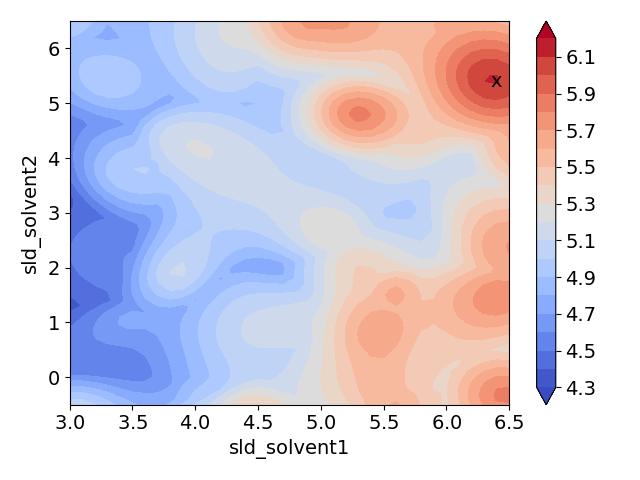

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/plots/prediction_gpcam_sld_solvent0_sld_solvent2.png


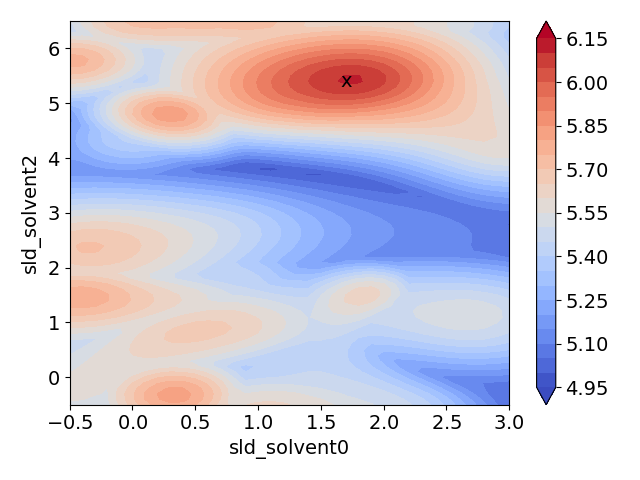

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/plots/prediction_gpcam_sld_solvent0_sld_solvent1.png


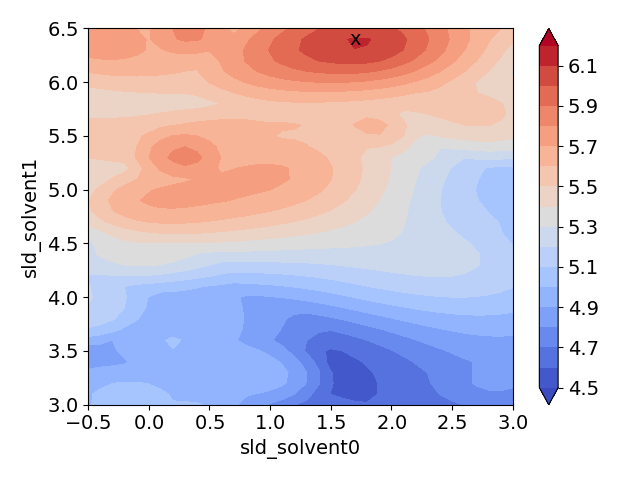

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/plots/prediction_gpcam_frac_deut_sld_solvent2.png


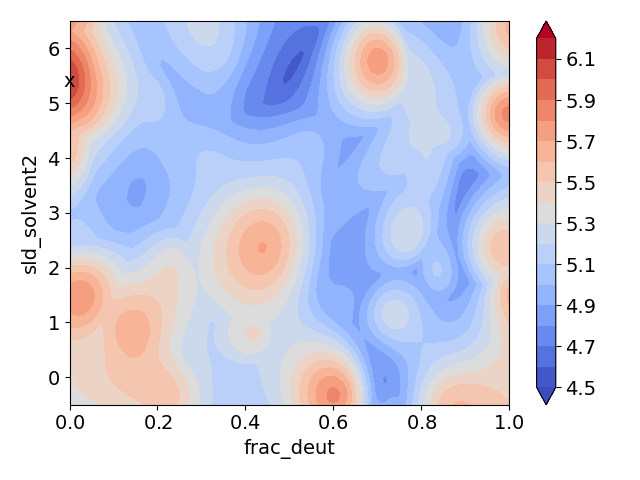

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/plots/prediction_gpcam_frac_deut_sld_solvent0.png


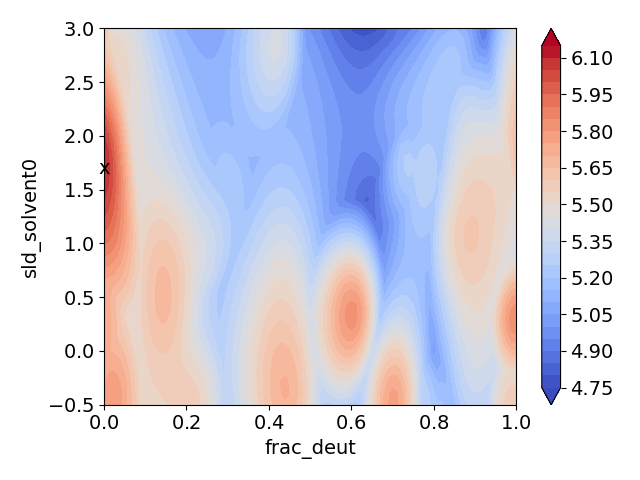

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/experimental_optimization/SANS/LUV_d54DMPC_ThreeContrasts/plots/prediction_gpcam_frac_deut_sld_solvent1.png


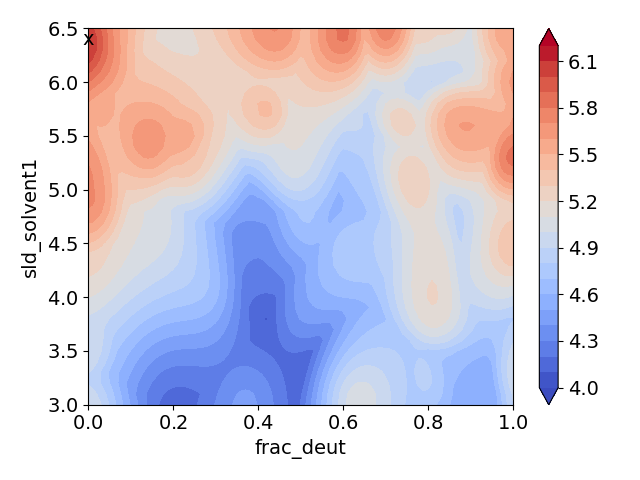

In [20]:
# entr.plot_results()
from IPython.display import Image, display
import glob
from os import path
for file in glob.glob(path.join(setupdir, 'plots', "*.png")):
    print(file)
    display(Image(filename=file))